## Final analysis of chlorophyll distribution and fish tag mapping (weekly)

In [16]:
import pandas as pd
import numpy as np
import re
from datetime import datetime
import xarray as xr

## Load csv

In [17]:
tag = pd.read_csv(
    "Red_rum_updated.csv",
    parse_dates=["week_utc"],
    skiprows=4
)
tag.head(2)

,tag_id,common_name,week_utc,latitude,longitude,n_days_detected
0,BCNCBO-1572494-2024-06-13,red drum,2024-06-10,38.727936,-76.336701,4.0
1,BCNCBO-1572494-2024-06-13,red drum,2024-06-17,38.727042,-76.338095,6.0


## Remove NaN rows

In [18]:
tag = tag[tag["week_utc"].notna()]

## Datetime

In [19]:
tag.loc[:, 'week_utc'] = pd.to_datetime(tag['week_utc'])
tag.head(2)

,tag_id,common_name,week_utc,latitude,longitude,n_days_detected
0,BCNCBO-1572494-2024-06-13,red drum,2024-06-10,38.727936,-76.336701,4.0
1,BCNCBO-1572494-2024-06-13,red drum,2024-06-17,38.727042,-76.338095,6.0


## Define the bounding box and date range

In [20]:
lat_range = (tag.latitude.min()-0.75, tag.latitude.max()+0.75)
lon_range = (tag.longitude.min()-0.75, tag.longitude.max()+0.75)
date_range = (tag.week_utc.min(), tag.week_utc.max())

## Login and search PACE data

In [21]:
import earthaccess
earthaccess.login()

In [22]:
results = earthaccess.search_datasets(instrument="oci") # search by sensor
for item in results[0:]:
    summary = item.summary()
    print(summary["short-name"])

PACE_OCI_L0_SCI
PACE_OCI_L1A_SCI
PACE_OCI_L1B_SCI
PACE_OCI_L1C_SCI
PACE_OCI_L2_UVAI_UAA_NRT
PACE_OCI_L2_UVAI_UAA
PACE_OCI_L2_AER_UAA_NRT
PACE_OCI_L2_AER_UAA
PACE_OCI_L2_AOP_NRT
PACE_OCI_L2_AOP
PACE_OCI_L2_CLOUD_MASK_NRT
PACE_OCI_L2_CLOUD_MASK
PACE_OCI_L2_CLOUD_NRT
PACE_OCI_L2_CLOUD
PACE_OCI_L2_IOP_NRT
PACE_OCI_L2_IOP
PACE_OCI_L2_LANDVI_NRT
PACE_OCI_L2_LANDVI
PACE_OCI_L2_BGC
PACE_OCI_L2_BGC_NRT
PACE_OCI_L2_PAR_NRT
PACE_OCI_L2_PAR
PACE_OCI_L2_SFREFL_NRT
PACE_OCI_L2_SFREFL
PACE_OCI_L3B_AOT_NRT
PACE_OCI_L3B_AOT
PACE_OCI_L3B_AVW_NRT
PACE_OCI_L3B_AVW
PACE_OCI_L3B_CARBON
PACE_OCI_L3B_CARBON_NRT
PACE_OCI_L3B_CHL_NRT
PACE_OCI_L3B_CHL
PACE_OCI_L3B_KD_NRT
PACE_OCI_L3B_KD
PACE_OCI_L3B_FLH_NRT
PACE_OCI_L3B_FLH
PACE_OCI_L3B_IOP_NRT
PACE_OCI_L3B_IOP
PACE_OCI_L3B_LANDVI_NRT
PACE_OCI_L3B_LANDVI
PACE_OCI_L3B_PIC_NRT
PACE_OCI_L3B_PIC
PACE_OCI_L3B_POC_NRT
PACE_OCI_L3B_POC
PACE_OCI_L3B_PAR_NRT
PACE_OCI_L3B_PAR
PACE_OCI_L3B_RRS_NRT
PACE_OCI_L3B_RRS
PACE_OCI_L3B_SFREFL_NRT
PACE_OCI_L3B_SFREFL
PACE_OCI_L3M_UV

## Select the 8D dataset

In [23]:
results = earthaccess.search_data(
    short_name="PACE_OCI_L3M_CHL",
    temporal=date_range,
    granule_name="*.8D.*.4KM.*"
)

len(results)

28

## Show 1st result


In [24]:

results[0]

Collection: {'Version': '3.1', 'ShortName': 'PACE_OCI_L3M_CHL'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'BoundingRectangles': [{'WestBoundingCoordinate': -180, 'NorthBoundingCoordinate': 90, 'SouthBoundingCoordinate': -90, 'EastBoundingCoordinate': 180}]}}}
Temporal coverage: {'RangeDateTime': {'EndingDateTime': '2024-06-16T23:59:59Z', 'BeginningDateTime': '2024-06-09T00:00:00Z'}}
Size(MB): 39.8583984375
Data: ['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20240609_20240616.L3m.8D.CHL.V3_1.chlor_a.4km.nc']

## Urls

In [25]:
[res.data_links() for res in results]

[['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20240609_20240616.L3m.8D.CHL.V3_1.chlor_a.4km.nc'],
 ['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20240617_20240624.L3m.8D.CHL.V3_1.chlor_a.4km.nc'],
 ['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20240625_20240702.L3m.8D.CHL.V3_1.chlor_a.4km.nc'],
 ['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20240703_20240710.L3m.8D.CHL.V3_1.chlor_a.4km.nc'],
 ['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20240711_20240718.L3m.8D.CHL.V3_1.chlor_a.4km.nc'],
 ['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20240719_20240726.L3m.8D.CHL.V3_1.chlor_a.4km.nc'],
 ['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20240727_20240803.L3m.8D.CHL.V3_1.chlor_a.4km.nc'],
 ['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20240804_202

## Set up a file pointer


In [26]:
fileset = earthaccess.open(results)

QUEUEING TASKS | :   0%|          | 0/28 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/28 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/28 [00:00<?, ?it/s]

## Load Data with xarray

In [27]:
datasets = []

for f in fileset:
    filename = f.info()['name']
    match = re.search(r'\d{8}', filename)
    if not match:
        continue

    start_date = datetime.strptime(match.group(), "%Y%m%d")
    week_time = pd.to_datetime(start_date).to_period("W-MON").start_time

    ds = xr.open_dataset(f, chunks={'lat':500, 'lon':500})[['chlor_a']]
    ds = ds.assign_coords(time=[week_time])
    datasets.append(ds)

ds_chl = xr.concat(datasets, dim="time")

/tmp/ipykernel_1008/2298186214.py:12: UserWarning: The specified chunks separate the stored chunks along dimension "lat" starting at index 500. This could degrade performance. Instead, consider rechunking after loading.
  ds = xr.open_dataset(f, chunks={'lat':500, 'lon':500})[['chlor_a']]
/tmp/ipykernel_1008/2298186214.py:12: UserWarning: The specified chunks separate the stored chunks along dimension "lon" starting at index 500. This could degrade performance. Instead, consider rechunking after loading.
  ds = xr.open_dataset(f, chunks={'lat':500, 'lon':500})[['chlor_a']]
/tmp/ipykernel_1008/2298186214.py:12: UserWarning: The specified chunks separate the stored chunks along dimension "lat" starting at index 500. This could degrade performance. Instead, consider rechunking after loading.
  ds = xr.open_dataset(f, chunks={'lat':500, 'lon':500})[['chlor_a']]
/tmp/ipykernel_1008/2298186214.py:12: UserWarning: The specified chunks separate the stored chunks along dimension "lon" starting 

 ## Subset region

In [28]:
ds_region = ds_chl.sel(
    lat=slice(lat_range[1], lat_range[0]),
    lon=slice(lon_range[0], lon_range[1])
)

## Plots

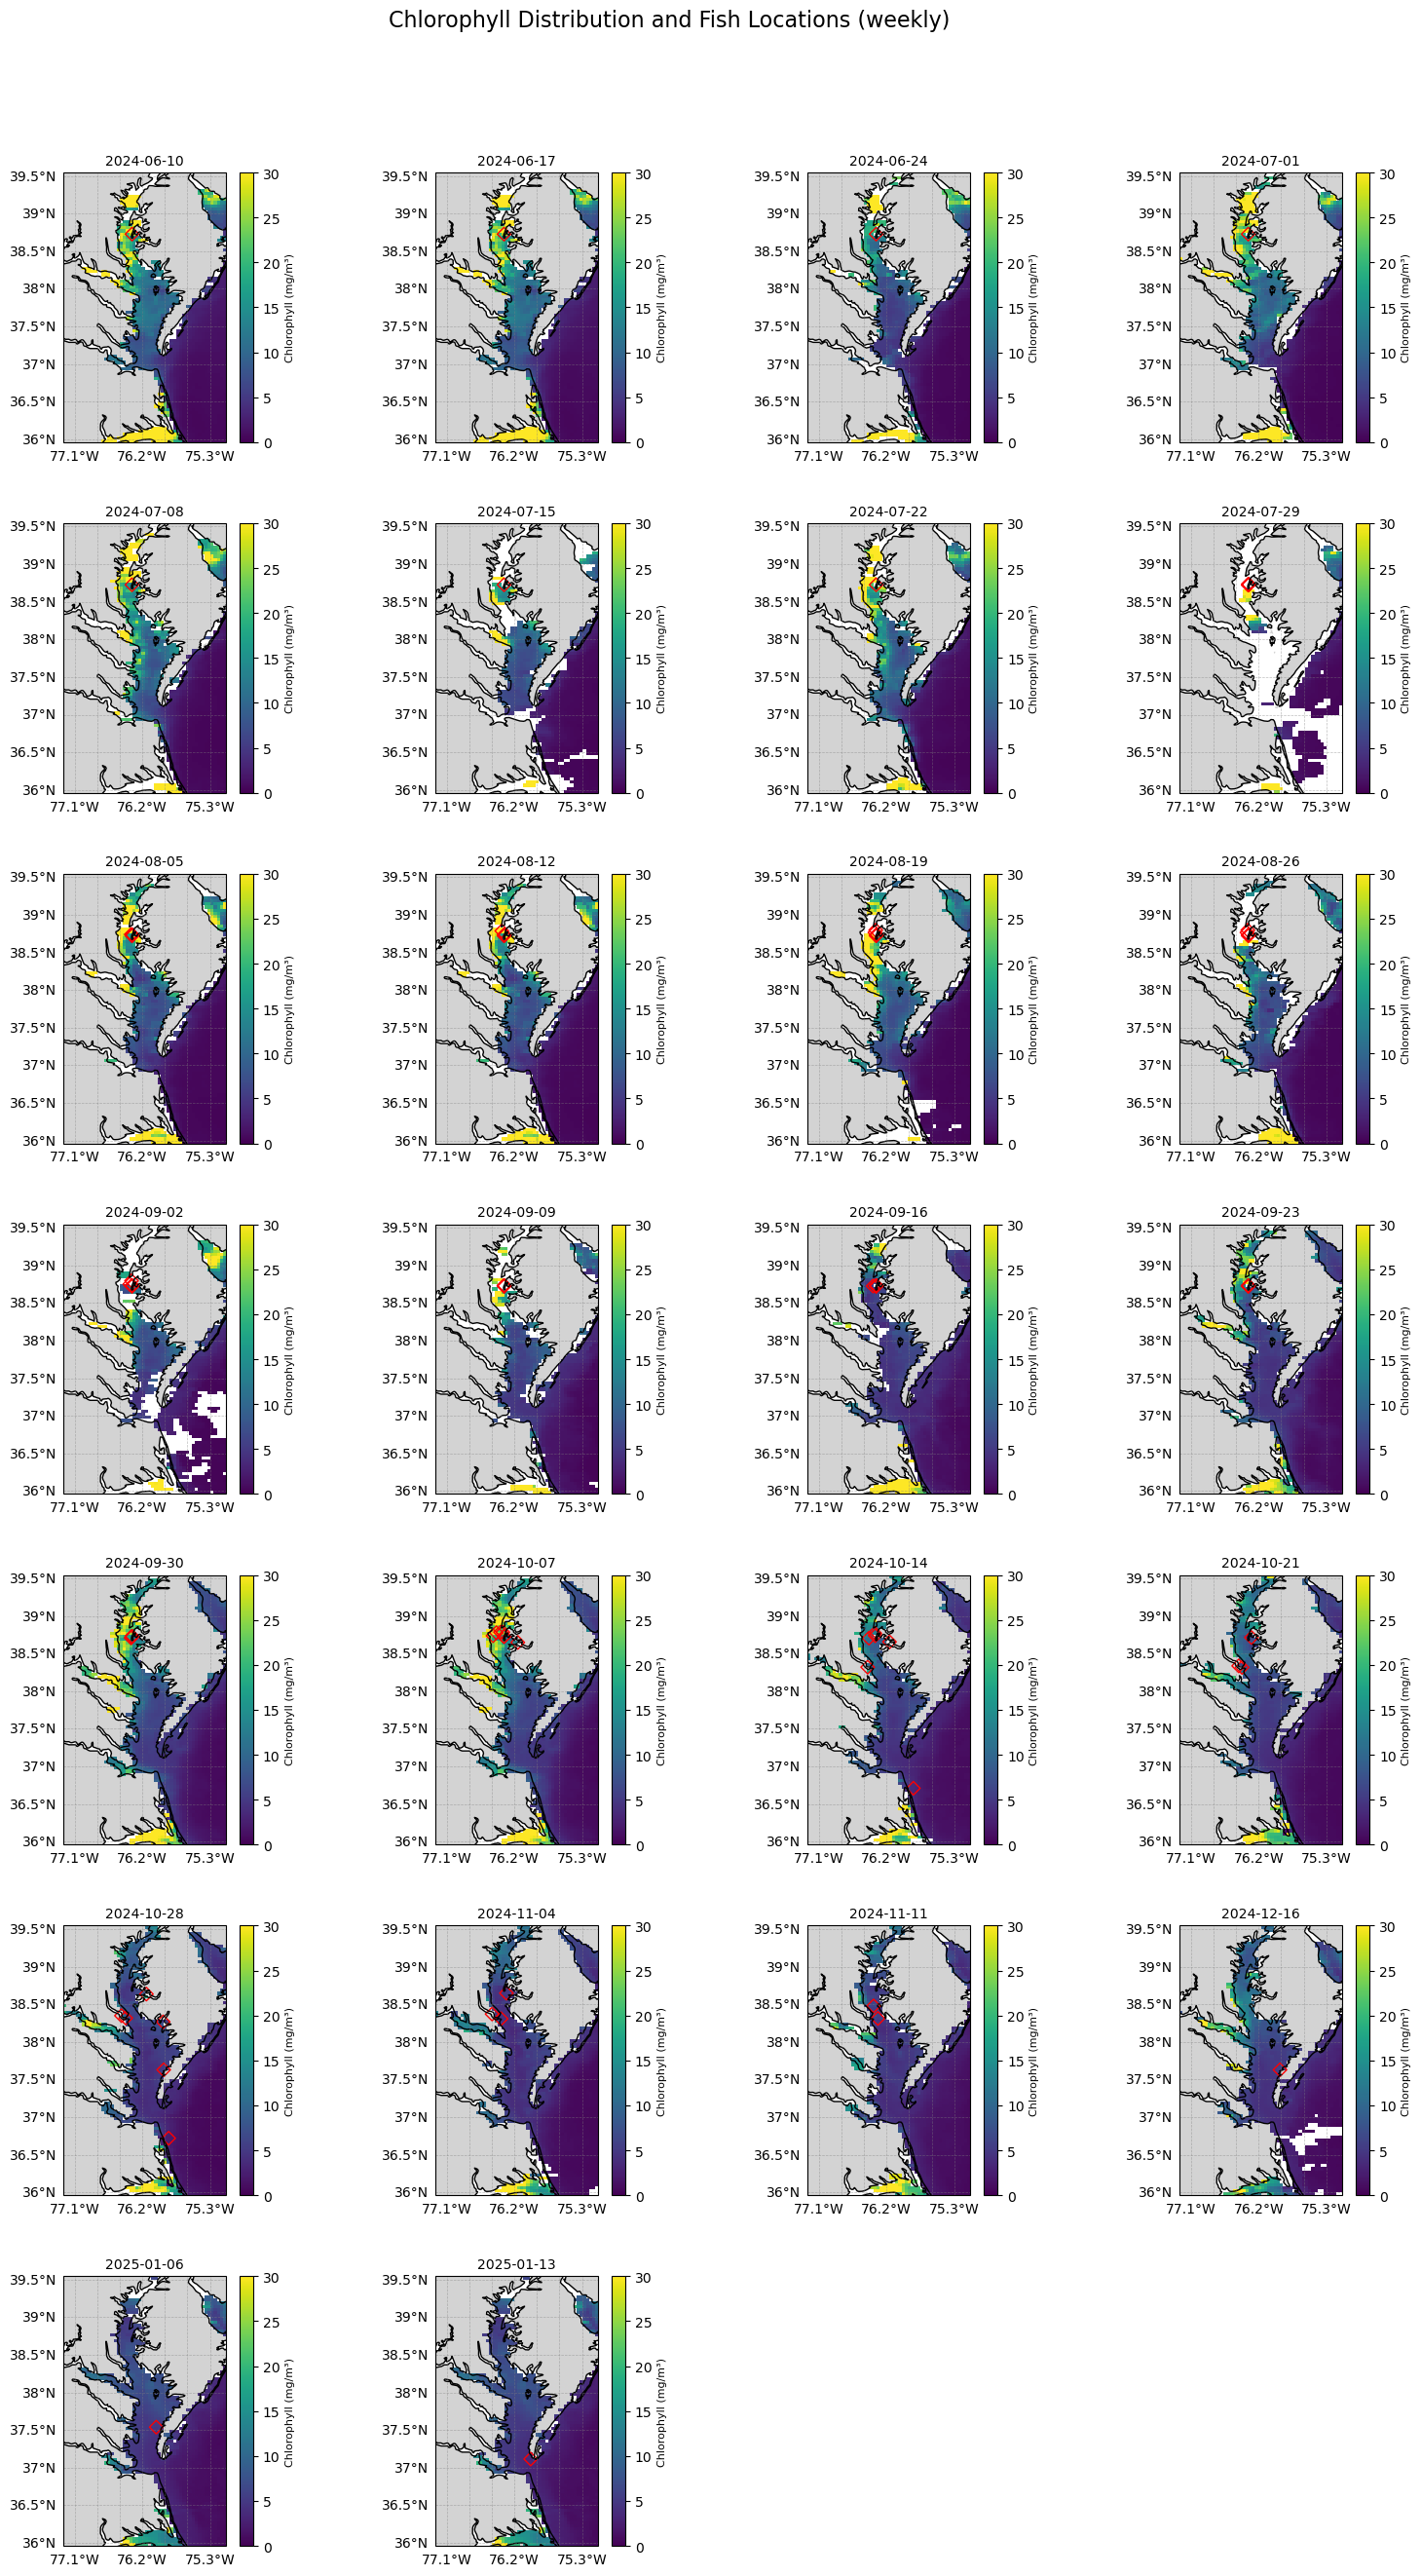

In [30]:
import math
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Unique weeks
weeks = tag.week_utc.sort_values().unique()
n_weeks = len(weeks)

# Grid layout
ncols = 4
nrows = math.ceil(n_weeks / ncols)

# Fixed colorbar range (0-30mg/m-3)
cbar_min = 0
cbar_max = 30

# Create figure and axes
fig, axs = plt.subplots(
    nrows=nrows, ncols=ncols,
    figsize=(ncols*4, nrows*4),
    subplot_kw={'projection': ccrs.PlateCarree()}
)
axs = axs.flatten()

for i, week in enumerate(weeks):
    ax = axs[i]
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.COASTLINE)

    # Gridlines
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': 10}
    gl.ylabel_style = {'size': 10}

    # Set map extent
    ax.set_extent([lon_range[0], lon_range[1], lat_range[0], lat_range[1]])

    # Select chlorophyll for week
    chl_plot = ds_region.sel(time=week, method="nearest")["chlor_a"]

    # Plot chlorophyll with fixed colorbar scale 
    mesh = ax.pcolormesh(
        chl_plot.lon,
        chl_plot.lat,
        chl_plot,
        cmap='viridis',
        shading='auto',
        vmin=cbar_min, 
        vmax=cbar_max   
    )

    # Plot fish locations
    fish_points = tag[tag.week_utc == week]
    ax.scatter(fish_points.longitude, fish_points.latitude, color='none', marker='D', edgecolor='red', s=50)

    ax.set_title(f"{week.date()}", fontsize=10)

    # Individual colorbar for each subplot
    cbar = fig.colorbar(mesh, ax=ax, orientation='vertical', fraction=0.05, pad=0.05)
    cbar.set_label("Chlorophyll (mg/m³)", fontsize=8)
    cbar.set_ticks([0, 5, 10, 15, 20, 25, 30])  

# Hide extra axes
for j in range(i+1, len(axs)):
    axs[j].axis('off')

# title and layout
fig.suptitle("Chlorophyll Distribution and Fish Locations (weekly)", fontsize=16, y=0.98)
fig.subplots_adjust(left=0.05, right=0.95, top=0.92, bottom=0.05, wspace=0.3, hspace=0.3)

# Save figure
plt.savefig("Weekly_CHL_RedDrum_viridis_each_colorbar_30.png", dpi=300)
plt.show()